INF8770 Technologies multimédias

Polytechnique Montréal

Importation des librairies

In [24]:
from PIL import Image
import os
from skimage.feature.texture import local_binary_pattern
import glob
import cv2
import numpy
import csv
import time
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage import io
import urllib.request as request

Importation des données

In [4]:
highway = glob.glob(os.path.join("./data/baseline/highway/input", "*.jpg"))
office = glob.glob(os.path.join("./data/baseline/office/input", "*.jpg"))
pedestrians = glob.glob(os.path.join("./data/baseline/pedestrians/input", "*.jpg"))
PETS2006 = glob.glob(os.path.join("./data/baseline/PETS2006/input", "*.jpg"))


highway_ref = glob.glob(os.path.join("./data/baseline/highway/groundtruth", "*.png"))
office_ref = glob.glob(os.path.join("./data/baseline/office/groundtruth", "*.png"))
pedestrians_ref = glob.glob(os.path.join("./data/baseline/pedestrians/groundtruth", "*.png"))
PETS2006_ref = glob.glob(os.path.join("./data/baseline/PETS2006/groundtruth", "*.png"))


# small_test_office = glob.glob(os.path.join("./data/baseline/small_test_office/input", "*.jpg"))
# small_test_office_ref = glob.glob(os.path.join("./data/baseline/small_test_office/groundtruth", "*.png"))


Background Substraction

In [3]:
def generate_background_substrated_image(image_path, background_image):
  threshold = 40
  image = (cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)).astype(float)

  diff = numpy.abs(image - background_image) >= threshold

  int_image = diff.astype(int)

  # plt.imshow(~int_image,plt.get_cmap('binary'))
  # plt.show()
  return int_image

Instance Segmentation

Loading images: 0.0
Model: 6.316586017608643
Label: car
Label: bird


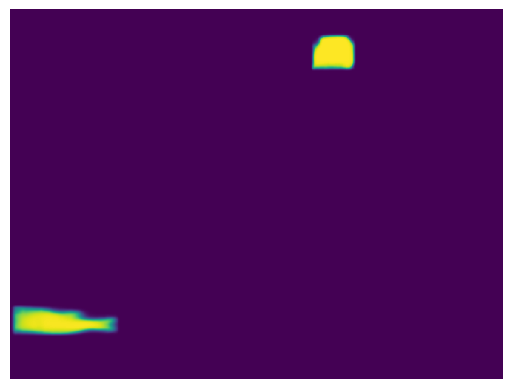

Label: car


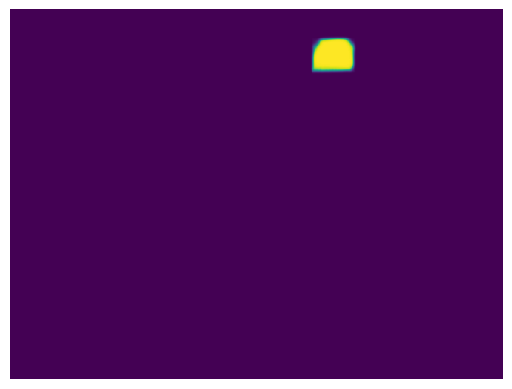

Prediction: 0.13324666023254395


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [26]:
COCO_NAMES = ['background']
label_names = request.urlopen('https://raw.githubusercontent.com/gabilodeau/INF6804/master/utils/coco-labels.txt')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

def Mask_RCNN(dataset):
  tensors = []
  preprocess = transforms.Compose([transforms.ToTensor()])
  THRESHOLD = 0.30
  result = []

  timestamp = time.time()
  
  for img_path in dataset:
    img = io.imread(img_path)
    tensors.append(preprocess(img))

  print(f"Loading images: {time.time() - timestamp}")
  timestamp = time.time()
    
  model = models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT').eval()
  predictions = model(tensors)

  print(f"Model: {time.time() - timestamp}")
  timestamp = time.time()

  for prediction in predictions:
    img_result = []
    
    for j, score in enumerate(prediction['scores']):
        if score >= THRESHOLD:
          
          print(f"Label: {COCO_NAMES[prediction['labels'][j]]}")
          mask = prediction['masks'][j][0].detach().numpy()
          if len(img_result) == 0:
            img_result = numpy.array(mask)
          else:
            img_result = numpy.maximum(img_result, mask)

    plt.imshow(img_result); plt.axis('off'); plt.show()
    result.append(img_result)
    
  print(f"Prediction: {time.time() - timestamp}")


  return result

Mask_RCNN(highway[102:104])

Méthode de comparaison

In [ ]:
def intersection(vector_i, vector_j):
    return numpy.sum(numpy.minimum(vector_i, vector_j)) / numpy.sum(vector_j)

def norms1(vector_i, vector_j):
    return numpy.sum(numpy.abs(vector_i - vector_j))

def norms2(vector_i, vector_j):
    return numpy.sqrt(numpy.sum(numpy.power(vector_i - vector_j, 2)))

def bhattacharyya(vector_i, vector_j):
    return -numpy.log((numpy.sum(numpy.sqrt(numpy.multiply(vector_i, vector_j)))))

Background Substraction

In [24]:
def substract_background(dataset, background_image_index):
    background_image = (cv2.imread(dataset[background_image_index], cv2.IMREAD_GRAYSCALE)).astype(float)

    result = []
    for path in dataset:
        result.append(generate_background_substrated_image(path, background_image))
    
    return result

result = substract_background(office, 0)

Classification par modèle binaire locaux

In [ ]:
def classify_LBP(query, database, longueurCodes, rayon, all):
    lbp_db_descriptors = []
    for path_db in database:
        row_lbp, col_lbp = cv2.imread(path_db, cv2.IMREAD_GRAYSCALE).shape
        lbp_hist_db, _ = numpy.histogram(desc_LBP(path_db, longueurCodes, rayon), bins = range(256))
        lbp_hist_db = lbp_hist_db / (row_lbp * col_lbp)
        lbp_db_descriptors.append(lbp_hist_db)

    for path_query in query:
        result = dict()

        lbp_query = desc_LBP(path_query, longueurCodes, rayon)

        row_lbp, col_lbp = cv2.imread(path_query, cv2.IMREAD_GRAYSCALE).shape

        lbp_hist_query, _ = numpy.histogram(lbp_query, bins = range(256))
        lbp_hist_query = lbp_hist_query / (row_lbp * col_lbp)

        methods = ["intersection", "norms1", "norms2", "bhattacharyya"]

        # path = path_query.split('\\')[1][:-4]
        # result_path = f"./results/LBP/R{rayon}-P{longueurCodes}"

        # os.makedirs(result_path, exist_ok=True)

        # with open(f"{result_path}/{path}.csv", 'w+', newline='') as file:
            # writer = csv.writer(file)
            # field = [path] + [x.split('\\')[1][:-4] for x in database]
            
        for key in methods:
            result[key] = []
        
        index = 0
        for path_db in database:
            lbp_hist_db = lbp_db_descriptors[index]

            result_id = path_query.split('\\')[1][:-4] + ":" + path_db.split('\\')[1][:-4]

            result["intersection"].append((result_id, intersection(lbp_hist_query, lbp_hist_db)))

            result["norms1"].append((result_id, norms1(lbp_hist_query, lbp_hist_db)))

            result["norms2"].append((result_id, norms2(lbp_hist_query, lbp_hist_db)))

            result["bhattacharyya"].append((result_id, bhattacharyya(lbp_hist_query, lbp_hist_db)))

            index += 1

            # writer.writerow([path + f" ({timeList[0]})"] + methods)

            # for f in range(1, len(field)):
            #     writer.writerow([field[f]] + [result[key][f - 1][1] for key in result.keys()])
        
        # for key in result.keys():
        #     if key not in all:
        #         all[key] = dict()
        #     reverse = True if (key == "intersection") else False
        #     data = [x[0] for x in sorted(result[key], key=lambda tp: tp[1], reverse=reverse)[:3]]
        #     for d in data:
        #         img_name = d.split(':')[0][:-6]
        #         db_name = d.split(':')[1][:-2]
        #         if "strawberry" in img_name:
        #             if img_name not in all[key]:
        #                 all[key][img_name] = dict()
        #             if db_name not in all[key][img_name]:
        #                 all[key][img_name][db_name] = 0
        #             all[key][img_name][db_name] += 1
        #         else:
        #             if img_name not in all[key]:
        #                 all[key][img_name] = (0, 0)
        #             if img_name == db_name:
        #                 all[key][img_name] = (all[key][img_name][0] + 1, all[key][img_name][1])
        #             all[key][img_name] = (all[key][img_name][0], all[key][img_name][1] + 1)

all = dict()

timestamp = time.time()
for rayon in range(1, 6, 2):
    for longueurCodes in range(4, 25, 4):
        classify_LBP(query, database, longueurCodes, rayon, all)

print(f"Time Normal: {time.time() - timestamp}")

timestamp = time.time()
for rayon in range(1, 6, 2):
    for longueurCodes in range(4, 25, 4):
        classify_LBP(query_cropped, database_cropped, longueurCodes, rayon, all)
print(f"Time Cropped: {time.time() - timestamp}")

# print(all)